# 示範指令使用

### 用指令算 3gram 

In [1]:
!egrep -o '([^ ]+ ){2}[^ ]+' VOA.txt | tr 'A-Z' 'a-z' | \
sort -r  | uniq -c | awk '{if ($1 > 1) printf "%s %s %s\t%s\n",$2,$3,$4,$1 }' | \
head -20

zurich protested the	2
zuhir al-naimi ,	3
zuhayr talib abd	4
zubaidi does not	2
zoran zivkovic said	2
zoran zivkovic ,	2
zoran djindjic has	2
zoran djindjic .	10
zora neale hurston	8
zones over northern	2
zone that divides	2
zone monday attacked	2
zone in the	3
zone between north	3
zone along the	2
zone about 370	2
zone , where	2
zoellick formalized the	2
zivkovic possible candidacy	2
zimbabwean president robert	2
awk: write error on stdout
 input record number 6909, file 
 source line number 1
uniq: write error: Broken pipe


### 縮小檔案基本方法
- `wc -l file` 算行數
- `head -# file > new_file`  取前 # 行
- `head -c #m > new_file` 取前 #mb 資料

-----

# Lab3開始

# word tokenize
- 使用 nltk, pattern 或 textblob 做 word tokenize。這邊統一使用 nltk 的 wordpunct_tokenize 切字。
- 資料取原始檔案的前 50000 行

# 計算 skip bigram 

- $p_j^i$ 
- ngram 任何位置不包含符號
- skip bigram 不包含 stop words 與數字

In [1]:
from __future__ import division

k0 = 1
k1 = 1
U0 = 10
max_distance = 5

In [2]:
# 示範 code ，修改下列 code 達到目的
# 可跳過 ngram ，直接計算 skip bigram
from nltk.tokenize import  wordpunct_tokenize 
from nltk.corpus import stopwords 
eng_stopwords = set(stopwords.words('english'))
eng_symbols = '{}"\'()[].,:;+!?-*/&|<>=~$'
def ngram_is_valid(ngram):
    first, last = ngram[0], ngram[-1]
    if first in eng_stopwords or last in eng_stopwords: return False
    if any( num in first or num in last for num in '0123456789'): return False
    if any( eng_symbol in word for word in ngram for eng_symbol in eng_symbols): return False
    return True

from collections import defaultdict, Counter
def to_ngrams( unigrams, length):
    return zip(*[unigrams[i:] for i in range(length)])  

from nltk.tokenize import  wordpunct_tokenize 
ngram_counts = defaultdict(Counter)
with open('citeseerx_descriptions_sents.txt.50000') as text_file:
    for index,line in enumerate(text_file): 
        words = wordpunct_tokenize(line)
        for n in range(2, max_distance + 2):
            ngram_counts[n].update(filter(ngram_is_valid, to_ngrams(words, n)))

In [3]:
skip_bigram_info = defaultdict(lambda: defaultdict(Counter))

for distance in ngram_counts:
    for keys in list(ngram_counts[distance].keys()):        
        skip_bigram_info[keys[0]][keys[-1]] += Counter({distance-1:ngram_counts[distance][keys]})
        skip_bigram_info[keys[-1]][keys[0]] += Counter({-distance+1:ngram_counts[distance][keys]})


In [4]:
list(skip_bigram_info['role'].items())[:10]

[('hierarchy', Counter({1: 2})),
 ('box', Counter({1: 1})),
 ('called', Counter({-1: 2})),
 ('absorption', Counter({-3: 1, 1: 1})),
 ('fundamental', Counter({-1: 3, 3: 1})),
 ('pivotal', Counter({-1: 3})),
 ('precise', Counter({-1: 1})),
 ('possible', Counter({-5: 1, -1: 2})),
 ('central', Counter({-1: 11, 3: 1, 4: 1})),
 ('future', Counter({-5: 1, -1: 1, 2: 2, 4: 1}))]

In [5]:
skip_bigram_info['play']['role']

Counter({-5: 1, -4: 2, -2: 2, 2: 8, 3: 51, 4: 5, 5: 1})

### 階段檢查資料


In [8]:
list(skip_bigram_info['role'].items())[:10]

[('hierarchy', Counter({1: 2})),
 ('box', Counter({1: 1})),
 ('called', Counter({-1: 2})),
 ('absorption', Counter({-3: 1, 1: 1})),
 ('fundamental', Counter({-1: 3, 3: 1})),
 ('pivotal', Counter({-1: 3})),
 ('precise', Counter({-1: 1})),
 ('possible', Counter({-5: 1, -1: 2})),
 ('central', Counter({-1: 11, 3: 1, 4: 1})),
 ('future', Counter({-5: 1, -1: 1, 2: 2, 4: 1}))]

In [9]:
skip_bigram_info['play']['role']

Counter({-5: 1, -4: 2, -2: 2, 2: 8, 3: 51, 4: 5, 5: 1})

# 計算 skip bigram 的各種統計資訊 
$freq,\ \bar{f},\ \sigma,\ u_i,\ \bar{p_i}$

In [6]:
def calculate_deviation(my_list, average):
    variance = 0
    for i in range(0, len(my_list)):
        variance += (average - my_list[i]) ** 2
    return (variance / len(my_list)) ** 0.5


def grades_average(my_list):
    sum_of_grades = sum(my_list)
    average = sum_of_grades / len(my_list)
    return average

def calculate_spread(my_list, average):
    # Need to fill up len(my_list) to 10's 0 when my_list < 10
    spread = 0
    for i in range(0, len(my_list)):
        spread += (my_list[i] - average) ** 2
    return spread/len(my_list)

In [7]:
skip_bigram_abc = defaultdict(lambda: defaultdict(Counter))
for index, word1 in enumerate(skip_bigram_info):
    total_frequency_list = []
    for word2 in skip_bigram_info[word1]:
        frequency_p_list = list(skip_bigram_info[word1][word2].values())
        frequency_p_list = frequency_p_list + [0] * (10 - len(frequency_p_list))
        
        two_word_frequency = sum(frequency_p_list)
        total_frequency_list.append(two_word_frequency)

        skip_bigram_abc[(word1,word2,'freq')] = two_word_frequency
        skip_bigram_abc[(word1, word2, 'spread')] = calculate_spread(frequency_p_list, grades_average(frequency_p_list))
        
    skip_bigram_abc[(word1,'avg_freq')] = sum(total_frequency_list) / len(total_frequency_list)
    skip_bigram_abc[(word1, 'dev')] = calculate_deviation(total_frequency_list, grades_average(total_frequency_list))


### 階段檢查資料
- $\bar{f}$ : `avg_freq`
- $\sigma$ : `dev`  標準差
- $u_i$ : `spread`  將十個值各自減掉 所有平律的平均 在平方起來加起來平均 
- $freq$ : `freq`


In [24]:
print(skip_bigram_info["play"]["role"])
print(skip_bigram_abc[('play','avg_freq')])
print(skip_bigram_abc[('play','dev')])
print(skip_bigram_abc[('play','role','spread')])
print(skip_bigram_abc[('play','role','freq')])

Counter({3: 51, 2: 8, 4: 5, -2: 2, -4: 2, 5: 1, -5: 1})
1.5247524752475248
defaultdict(<class 'collections.Counter'>, {})
4.197108998898267
221.0
70


## 使用 pandas 畫出 play role 的各距離數量 

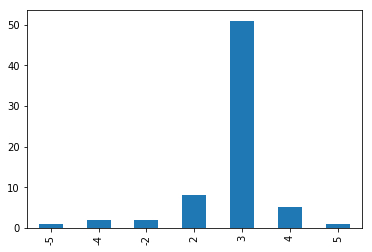

In [48]:
import pandas 
%matplotlib inline
play_role_distances_count = pandas.Series(list(skip_bigram_info['play']['role'].values()), index= list(skip_bigram_info['play']['role'].keys())).sort_index()
play_role_distances_count.plot(kind='bar')

# 依據 Smadja’s 三個規則篩選 skip bigrams

$$\begin{cases} 
strength = \frac{freq - \bar{f}}{\sigma} \ge k_0 & (C_1)\\
spread \ge u_0 & (C_2) \\
p_j^i \ge \bar{p_i} + (k_1 \times \sqrt{u_i}) & (C_3) 
\end{cases}$$

In [30]:
def calcute_strength(freq, avg_freq, dev):
    if dev == 0:
        return (freq - avg_freq) / 1
    else:
        return (freq - avg_freq) / dev

def calcute_peak(frequency_in_each_distance_list, spread):
    avg = sum(frequency_in_each_distance_list) / 10
    return avg + spread ** 0.5

In [39]:
cc = []
for index, word1 in enumerate(skip_bigram_info):
    for word2 in skip_bigram_info[word1]:    
        spread = skip_bigram_abc[(word1, word2, 'spread')]
        strength = calcute_strength(skip_bigram_abc[(word1, word2, 'freq')], skip_bigram_abc[(word1, 'avg_freq')], skip_bigram_abc[(word1,'dev')])
        peak = calcute_peak(list(skip_bigram_info[word1][word2].values()), spread)
        
        for distance in skip_bigram_info[word1][word2].keys():
            p = skip_bigram_info[word1][word2][distance]
            if strength >= 1 and spread >= 10 and skip_bigram_info[word1][word2][distance] >= peak:
                cc.append((word1, word2, distance, strength, spread, peak, p))
        

## 使用 pandas Dataframe 整理與顯示資料

In [40]:
# cc = [('base word', 'collocate', 'distance', 'strength', 'spread', 'peak', 'p').......]
import pandas
collocations_df = pandas.DataFrame(cc,
                                   columns = ['base word', 'collocate', 'distance', 'strength', 'spread', 'peak', 'p'])
collocations_df = collocations_df.set_index(['base word', 'collocate', 'distance']).sort_index()

### 列出 collocation Dataframe

In [49]:
collocations_df

strength    spread        peak    p
base word collocate    distance                                      
#         #            -2        38.086420    506.56   87.706888  107
                        2        38.086420    506.56   87.706888  107
          The          -3         2.043375     13.16    7.427671   10
                       -2         2.043375     13.16    7.427671    8
          We           -5         1.338951     20.04    7.076606    8
                       -4         1.338951     20.04    7.076606   14
          c             1         2.160779    114.20   14.686440   36
          ciency        1         2.747799    178.60   18.364131   45
          cient         1         8.852810   2043.44   60.604425  151
          ciently       1         2.160779    128.60   15.340194   38
          coe          -1         1.221547     43.04    8.960488   22
          cult          1         1.867269    103.45   13.671037   34
          di           -1        20.769322   9893.61  135.166628  334
          e            -1        24.115337  11877.84  150.385504  368
          ect           1         2.043375    115.36   14.540577   36
          ective        1         3.158714    270.21   22.138066   55
          ectively      1         1.162845     47.61    9.200000   23
          ects          1         1.984673    109.21   14.150359   35
          er            1         1.867269     96.85   13.341240   33
          erent         1        12.492336   3617.24   81.743495  202
          erential      1         1.456355     59.96   10.543384   26
          ers           1         1.456355     59.96   10.543384   26
          n            -1         2.512991     24.44    9.543683   16
                        1         2.512991     24.44    9.543683   12
          su           -1         2.865203    223.16   20.138541   50
          tra          -1         1.749865     85.61   12.552567   31
          two          -2         1.808567     15.84    7.379950   13
                        3         1.808567     15.84    7.379950    8
          usion         1         1.104143     43.56    8.800000   22
          x            -1         2.571693     52.41   11.939475   24
...                                    ...       ...         ...  ...
work      This         -1        18.888210    537.56   34.385340   79
          contribution -3         1.660808     10.76    4.480244   11
          done          1         4.072645     15.44    6.529377    8
                        3         4.072645     15.44    6.529377   11
          earlier      -1         2.349904     17.24    5.752108   14
          future       -1         4.244919     41.81    9.166065   22
          main         -4         2.005356     12.64    4.955278   12
          paper        -4         6.484481     28.20    9.310367   13
                       -3         6.484481     28.20    9.310367   15
          present      -2         4.417193     11.56    6.200000    7
                       -1         4.417193     11.56    6.200000   11
          previous     -1        13.547716    469.09   29.758486   73
          progress      2         2.005356     12.64    4.955278   12
          recent       -1         4.244919     60.41   10.472387   26
          well          1         1.833082     10.61    4.557299   11
works     previous     -1         9.569996     14.84    5.452272   13
world     data          1         5.351246     12.21    5.194281   12
          real         -1        22.833347    390.81   26.468915   66
          virtual      -1         3.952678     10.61    4.557299   11
worst     case          1        11.213565     43.21    8.873431   22
would     allow         1         6.998167     10.76    4.480244   11
          like          1        14.299831     31.81    7.940035   19
x         #            -1        10.766888     52.41   11.939475   12
                        1        10.766888     52.41   11.939475   24
years     In           -2         8.225192  

In [50]:
collocations_df.loc['role']

,,strength,spread,peak,p
collocate,distance,,,,
The,-1,5.058224,19.49,6.314748,15
central,-1,3.306837,10.61,4.557299,11
important,-1,11.771874,134.96,15.817229,39
play,-3,19.945013,221.00,21.866069,51
plays,-3,7.393407,34.01,8.531809,20


### 依據 strength 排序 collocation

In [54]:
collocations_df.sort_values(by = 'strength', ascending=False)[:10]

strength     spread        peak     p
base word collocate distance                                        
This      paper      1        48.524433  342586.69  782.409055  1953
also      We        -1        43.127860   13829.36  159.398299   394
In        paper      2        39.951056  288595.41  720.910769  1795
#         #          2        38.086420     506.56   87.706888   107
                    -2        38.086420     506.56   87.706888   107
present   We        -1        37.228588   43512.69  284.696956   700
order     In        -1        36.925210    3010.44   73.267477   183
show      We        -1        36.293592   13484.29  167.221876   388
paper     This      -1        35.929941  342586.69  782.409055  1953
The       paper      1        35.083989    7977.44  138.716516   295

### collocation Dataframe 的各欄位統計數據

In [55]:
collocations_df.describe()

,strength,spread,peak,p
count,5576.000000,5576.000000,5576.000000,5576.000000
mean,7.702521,386.152507,11.887454,24.892755
std,5.055714,8566.186232,24.459313,60.077982
min,1.010727,10.000000,4.400000,5.000000
25%,3.870956,14.040000,5.800000,12.000000
50%,6.714164,22.890000,7.570744,15.000000
75%,10.316805,51.840000,11.200000,23.000000
max,48.524433,342586.690000,782.409055,1953.000000


### role 的相關 collocations

In [56]:
collocations_df.loc['role']

,,strength,spread,peak,p
collocate,distance,,,,
The,-1,5.058224,19.49,6.314748,15
central,-1,3.306837,10.61,4.557299,11
important,-1,11.771874,134.96,15.817229,39
play,-3,19.945013,221.00,21.866069,51
plays,-3,7.393407,34.01,8.531809,20


### strength 的數據分佈

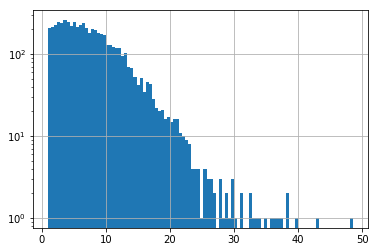

In [57]:
collocations_df.strength.hist(bins=100, log=True)

### 複雜篩選處理示範

In [59]:
collocations_df[ collocations_df.index.map(lambda x: x[2] == 1) & (collocations_df.spread > 800)  & (collocations_df.peak > 1000)
                ].sort_values(by='strength', ascending=False)[:20]

,,,strength,spread,peak,p
base word,collocate,distance,,,,


# BONUS!!!
使用 `citeseerx100000.tag.txt` 找出 VN 關係的 collocations